---
title: "Model Evaluation Metrics"
author: Daniel Redel
date: today
format:
  html:
    toc: true
    code-fold: false
    html-math-method: katex
jupyter: python3
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

There are 3 different APIs for evaluating the quality of a model’s predictions:

1. **Estimator default's `score` method**: Estimators have a `score` method providing a default evaluation criterion for the problem they are designed to solve.
2. **Scoring parameter**: Model-evaluation tools using cross-validation (such as `model_selection.cross_val_score` and `model_selection.GridSearchCV`) rely on an **_internal scoring strategy_**.
3. **Metric functions**: The `sklearn.metrics` module implements functions assessing prediction error for specific purposes. These metrics are detailed in sections.

# 1. Classification Metrics with `sklearn.metrics`

Our aim here is to use an evaluation rule to estimate the performance of a trained classifier. In this section, we will cover different metrics to measure various aspects of a classifier performance.

The `sklearn.metrics` module implements several loss, score, and utility functions to measure classification performance:
- **Accuracy**: `accuracy_score(y_true, y_pred)`
- **Confusion Matrix**: `confusion_matrix(y_true, probas_pred)`
- **Recall**: `recall_score(y_true, probas_pred)`
- **Precision**: `precision_score(y_true, probas_pred)`
- **$F_1$ Score**: `f1_score(y_true, y_pred)`

In [2]:
#| label: tbl-raw-dataset
#| tbl-cap: Iris Dataset
#| code-fold: true

from sklearn import datasets
iris = datasets.load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Add target
df['target'] = iris.target

# Dictionary
target_names_dict = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}

# Add the target names column to the DataFrame
df['target_names'] = df['target'].map(target_names_dict)
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as kNN

# Target vs Inputs
X = df.drop(columns=["target", "target_names"]) # Covariates-Only
y = df["target"] # Target-Outcome

# Train vs Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=0)

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 

# Instantiate Class into Object. Set Parameters
knn = kNN(n_neighbors=3)

# Train Model
knn.fit(X_train, y_train)

# Predict
y_test_pred = knn.predict(X_test)

## 1.1. Accuracy, Precision, Recall in `sklearn.metrics`

 For **multiclass** **classification** (such as this example), functions such as `precision_score` and `recall_score` supports `average=['macro', 'weighted', 'micro']`. 
 
 - If we set `average="None"` to print these metrics **for each class individually** (when the class is considered positive).

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy Score', accuracy_score(y_test, y_test_pred).round(2) ) 
print('Precision Score (Macro)', precision_score(y_test, y_test_pred, average='macro').round(2) ) 
print('Recall Score (Macro)', recall_score(y_test, y_test_pred, average='macro').round(2) ) 

Accuracy Score 0.97
Precision Score (Macro) 0.97
Recall Score (Macro) 0.97


## 1.2. Confusion Matrix Display

The `confusion_matrix` function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class (Wikipedia and other references may use different convention for axes).

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true = [0, 0, 0, 1, 1, 1, 1, 1, 0, 0]
y_pred = [0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
confusion_matrix(y_true, y_pred, normalize='all')

array([[0.4, 0.1],
       [0.2, 0.3]])

`ConfusionMatrixDisplay` can be used to visually represent a confusion matrix as shown in the Confusion matrix example, which creates the following figure:

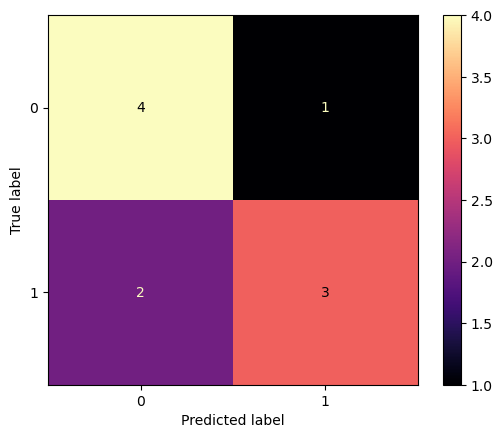

In [23]:
#| label: fig-cm1
#| fig-cap: Confusion Matrix Results
#| code-fold: true

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='magma')
plt.show()

- The parameter `normalize` allows to report **ratios** instead of counts. 
- The confusion matrix can be normalized in 3 different ways: `pred`, `true`, and `all` which will divide the counts by the sum of each columns, rows, or the entire matrix, respectively.
- The `cmap` controls in `.plot()` defines the color palette. default is `viridis`. Others are `magma`, `plasma`, `mako`, `inferno`.

## 1.3. Metrics using `scoring` from `sklearn.model_selection`

In order to use one of the aforementioned metrics along with **cross-validation**, we can set the scoring parameter of `cross_validate` or `cross_val_score` to a string that represents the metric.

Model selection and evaluation using tools, such as `model_selection.cross_val_score` and `model_selection.GridSearchCV`, take a `scoring` parameter that controls what metric they apply to the estimators evaluated.

The following list below shows some common possible values.

For **Classification**:

- **'accuracy'**: [`metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
- **'precision'**: [`metrics.precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
- **'recall'**: [`metrics.recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
- **'f1_macro'**: [`metrics.f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)
- **'roc_auc'**: [`metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)


### `cross_validate`

In [26]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.model_selection import cross_validate

# Instantiate Class into Object. Set Parameters
knn = kNN(n_neighbors=3)

# Call Multiple Metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'roc_auc_ovr', 'r2', 'neg_mean_squared_error']

# Cross validation and performance evaluation
knn_score = cross_validate(knn, X, y, cv=5, scoring=scoring) 

# Scores
knn_score = pd.DataFrame(knn_score)
knn_score

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_roc_auc_ovr,test_r2,test_neg_mean_squared_error
0,0.003936,0.018189,0.966667,0.969697,0.966667,0.973333,0.95,-0.033333
1,0.002517,0.014405,0.966667,0.969697,0.966667,1.000000,0.95,-0.033333
2,0.001958,0.016940,0.933333,0.944444,0.933333,0.990000,0.90,-0.066667
3,0.001999,0.016462,0.966667,0.969697,0.966667,0.971667,0.95,-0.033333
4,0.003011,0.013062,1.000000,1.000000,1.000000,1.000000,1.00,-0.000000


# 2. Regression Metrics in `sklearn.metrics`

Our aim now is to estimate the predictive ability of the regressor. We will apply the three most common metrics: **MSE**, **RMSE**,  **MAE**, and **R2**, also known as coefficient of determination.

The `sklearn.metrics` module implements several loss, score, and utility functions to measure regression performance. Some of those have been enhanced to handle the multi-output case: 

- **MSE**: [`mean_squared_error(y_true, y_pred)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) 
- **RMSE**: [`mean_root_squared_error(y_true, y_pred)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_root_squared_error) 
- **MAE**: [`mean_absolute_error(y_true, y_pred)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)
- **$R^2$**: [`r2_score(y_true, y_pred)`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)


## 2.1. Metrics using `scoring` from `sklearn.model_selection`

Model selection and evaluation using tools, such as `model_selection.cross_val_score` and `model_selection.GridSearchCV`, take a `scoring` parameter that controls what metric they apply to the estimators evaluated.

The following list below shows some common possible values.

For **Regression**:

- **'neg_mean_squared_error'**: [`metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)
- **'neg_root_mean_squared_error'**: [`metrics.root_mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html#sklearn.metrics.root_mean_squared_error)
- **'r2'**: [`metrics.r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

**Important Note**: All scorer objects follow the convention that **higher return values are better than lower return values**. Thus metrics such as `metrics.mean_squared_error` are here available as `neg_mean_squared_error` which return the negated value of the metric.